## Извлечение отношений

Традиционно извлечение отношений решается как задача классификации. Нужно связать именованные сущности в предложении какими-то заранее известными типами связей. Чаще всего это отношения вроде work_at, born_in, located_in, head_of. В биомедициских текстах извлечение отношений применяется для извлечения взаимодействия белков и поиска пар (лекарство, болезнь). Количество аргументов вообще может быть любым, но чаще всего ограничиваются бинарными отношениями (субъект, предикат, объект). 

Посмотрим как это работает на размеченном датасете.

Данные - https://github.com/thunlp/FewRel/blob/master/data/train.json


FewRel - это датасет для few-shot обучения. Это немного другая задача, для которой нужна нейронная сеть с определенной архитектурой и тест сет тут состоит из отношений других типов. Подробнее про задачу и датасет можно почитать вот тут - https://arxiv.org/pdf/1810.10147v1.pdf.

Мы его будем использовать для обычной классификации. Оценивать качество будем на кросс-валидации.


In [1]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import spacy
#nlp = spacy.load('en_core_web_sm')
from scipy.sparse import coo_matrix

In [1]:
#import gensim.downloader as api

In [9]:
from gensim.models import KeyedVectors

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [2]:
#model = api.load('glove-wiki-gigaword-300')#https://github.comRaRe/-Technologies/gensim-data
# в 4 Гб памяти не впихнуть модные модели с каггла про квору, печялька

[==================================================] 100.0% 376.1/376.1MB downloaded


In [4]:
#model.save("word2vec.model")

In [10]:
model = KeyedVectors.load("word2vec.model")

In [11]:
print(model.most_similar("cat"))

[('dog', 0.6816747188568115), ('cats', 0.6815836429595947), ('pet', 0.5870364904403687), ('dogs', 0.540766716003418), ('feline', 0.48979708552360535), ('monkey', 0.48794347047805786), ('horse', 0.4732130765914917), ('pets', 0.46348586678504944), ('rabbit', 0.4608757197856903), ('leopard', 0.4585462808609009)]


Посмотрим на данные.

In [12]:
data = json.load(open('../data/train.json'))

В датасете 64 типа отношений и у каждого типа 700 - предложений, в которых оно встречается.

In [13]:
len(data.keys())

64

Типы отношений обознчаются как-то условно, но в статье про датасет можно посмотреть соответствие.

In [8]:
data.keys()

dict_keys(['P931', 'P4552', 'P140', 'P1923', 'P150', 'P6', 'P27', 'P449', 'P1435', 'P175', 'P1344', 'P39', 'P527', 'P740', 'P706', 'P84', 'P495', 'P123', 'P57', 'P22', 'P178', 'P241', 'P403', 'P1411', 'P135', 'P991', 'P156', 'P176', 'P31', 'P1877', 'P102', 'P1408', 'P159', 'P3373', 'P1303', 'P17', 'P106', 'P551', 'P937', 'P355', 'P710', 'P137', 'P674', 'P466', 'P136', 'P306', 'P127', 'P400', 'P974', 'P1346', 'P460', 'P86', 'P118', 'P264', 'P750', 'P58', 'P3450', 'P105', 'P276', 'P101', 'P407', 'P1001', 'P800', 'P131'])

In [9]:
c = Counter([len(data[k]) for k in data])

In [10]:
c

Counter({700: 64})

Каждый инстанс - это предложения и разметка. Ключ h - это главное слово, t - зависимое. Предложения разделены на токены и в разметке указаны слова, уникальный номер и индексы сущности в предложении.

In [11]:
data['P127'][0]

{'tokens': ['Amityville',
  'is',
  'the',
  'westernmost',
  'station',
  'on',
  'the',
  'Babylon',
  'Branch',
  'of',
  'the',
  'Long',
  'Island',
  'Rail',
  'Road',
  'in',
  'Suffolk',
  'County',
  ',',
  'New',
  'York',
  '.'],
 'h': ['babylon branch', 'Q4838506', [[7, 8]]],
 't': ['long island rail road', 'Q125943', [[11, 12, 13, 14]]]}

Для обучения нам нужно каким-то образом перевести такую разметку в один вектор и сопоставить ему тип отношения.

Как это сделать? 

Стандартный способ - достать контекст слева от первой сущности, между сущностями и после второй сущности. Левые и правые контексты можно ограничить каким-то числом (например, 3 слова). Для каждого контекста можно получить вектор обычными способами - например через TfidfVectorizer. Потом эти вектора конкатенируются в один.

Ещё в этот вектор можно добавить длину контекста, тэги сущностей, сами сущности, порядок сущностей и т.д.

In [14]:
# тут будем держать сущности
ent1 = []
ent2 = []

# тут будем хранить контексты
left = []
right = []
middle = []

# целые предложения тоже на всякий случай достанем
sents = []

# целевая переменная (тип отношений будет тут)
target = []


# проходим по типам отношений
for key in data:
    # по каждому инстансу
    for instance in data[key]:
        
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))
        
        
        # h и t не обязательно идут в таком порядке
        # чтобы достать контексты нужно понять что из них идет первым
        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'
        
        
        # индексы сущностей
        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        # левый контекст - это три слова слева от начала первой сущности
        # если слева меньше 3 слов, то добавим тэгов <START>
        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)
        
        # правый контекст - это 3 слова после последнего слова второй сущности
        # если справа меньше 3 слов, то добавим тэгов <END>
        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        # средний контекст - это слова между последний словом первой сущности 
        # и первым словом второй сущности
        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)  

In [14]:
print(left[:10])

[['domestic', 'flight', 'to'], ['point', 'changed', 'to'], ['stack', 'interchange', 'near'], ['main', 'alternate', 'of'], ['at', 'Okobo', 'and'], ['<START>', '<START>', '<START>'], ['Its', 'hub', 'is'], ['his', 'honour', 'and'], ['Nearest', 'airport', 'is'], ['nearest', 'airport', 'is']]


In [15]:
def get_embedding(text, model, dim):
    
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector

In [22]:
def make_vectors(lst):
    new_list = []
    for three in lst:
        new_list.append(get_embedding(three, model, 300))
    return(new_list)
        
left_vec, right_vec, middle_vec = make_vectors(left),make_vectors(right),make_vectors(middle)
X = csr_matrix(hstack([coo_matrix(left_vec),coo_matrix(middle_vec),coo_matrix(right_vec)]))
y  = np.array(target)

Для тфидф векторайзера склеим токены. Обучим один общий векторайзер на всех текстах, но можно для каждого контекста обучить свой. 

In [18]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
tfidf.fit(lefts_s + rights_s + middles_s)

l = tfidf.fit_transform(lefts_s)
r = tfidf.fit_transform(rights_s)
m = tfidf.fit_transform(middles_s)

X_tfidf = csr_matrix(hstack([l,m,r])) # чтобы можно было по индексам доставать

In [19]:
y_tfidf  = np.array(target)

Качество с tfidf, для сравнения

In [20]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))

for train_index, test_index in skf.split(X_tfidf, y_tfidf):
    # Можно конечно что-нибудь посложнее, но для примера хватит и логрега
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
print(metrics_micro/N)
print(metrics_macro/N)

[0.47415179 0.47415179 0.47415179]
[0.47059271 0.47415179 0.46706785]


Качество с эмбеддингами

In [25]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    # Можно конечно что-нибудь посложнее, но для примера хватит и логрега
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
    

In [26]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.39558036 0.39558036 0.39558036]
[0.39399559 0.39558036 0.38538913]


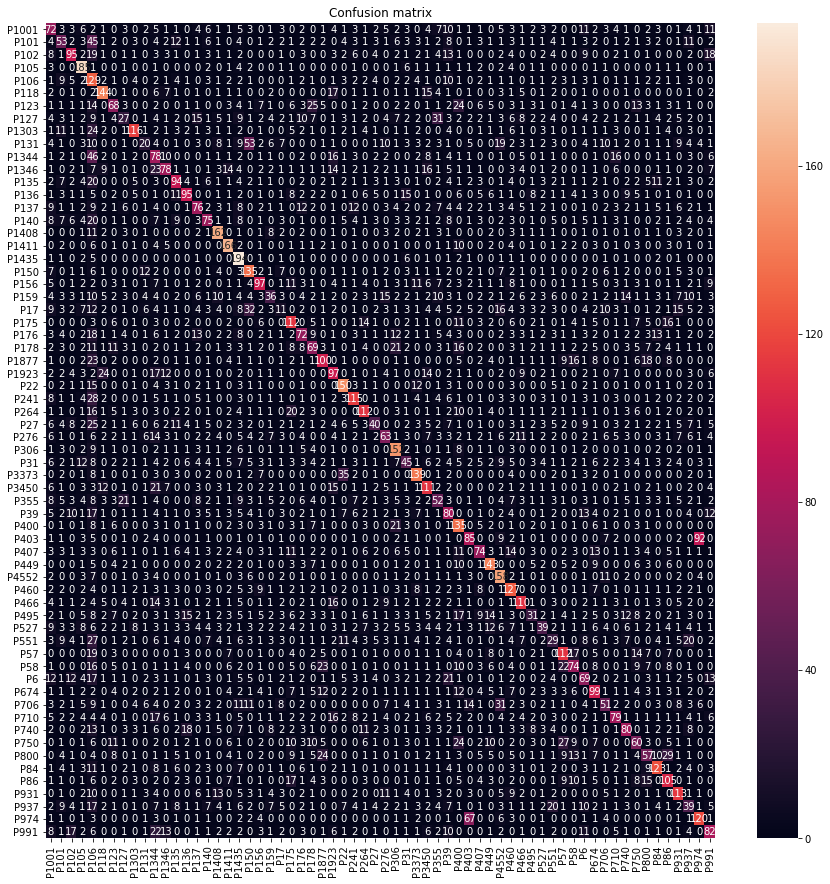

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Похоже, эмбеддинги с генсима меньше подходят для этой задачи, чем tfidf.

In [23]:
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))

for train_index, test_index in skf.split(X, y):
    clf = RandomForestClassifier(verbose=1) # чтобы не скучно было ждать
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
print(metrics_micro/N)
print(metrics_macro/N)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.31102679 0.31102679 0.31102679]
[0.32558043 0.31102679 0.31046734]


Все совсем плохо.

Посмотрим на Confusion matrix с логрегрессией.

Чаще всего путаются классы P403 и P974 - "the body of water to which the watercourse drain" и "stream or river that flows into this main stem (or parent) river". Действительно, эти отношения очень похожи, и контексты у входящих в них слов будут одинаковые. 

Реже, но чаще других путаются P131 и P150 - "located in the administra-
tive territorial entity" и "contains  administrative
territorial entity", по той же причине - контексты у слов похожи, хотя отношения противоположны друг другу.

Видно, что нужно учитывать не только контекстную схожесть, но и позиции слов. CRF должно работать лучше. Но sklearn_crfsuite надо подавать не sparse матрицу, а словарь, и непонятно, влезет ли в память, а времени до дедлайна мало.